<a href="https://colab.research.google.com/github/alemnew97de/Walmart-Data-Analysis-and-Forcasting/blob/main/Walmart_Data_Analysis_and_Forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'walmart-data-analysis-and-forcasting:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3186183%2F5526698%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240219%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240219T141912Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D51a299eca68e79c3653cd7563f7ed18dbebd390a7476446f482b8a2c44d79537cb99cdf30a32122b32d22f940fdd9047c087e71d9ff8bb738fadc90b873e174687c3cc912e3d9e2c3688e440fc5b326cc1ab56744aea8109531864c4acf8e609ef7b41abf48f802cc89bbab8e73f5ed668d056e525703b0ea658d5769171210f55a6598ae224e6edede8b78f0056e3d8b5af81bb661e21818829a903a7f8fb53b775aad1a99d6da2f04e63a9c53d8777b4c005c5422dbec90dc40e2e5beffc2e7572a7ba4a889f981f0a405bf8081813b9a45ea0899a7547bfac1078bcfd17cf86af3d908c4cafefa0a4021aee41fbe1de8183423a224b90425ec5151097fd96'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 125153 bytes downloaded
Downloaded and uncompressed: walmart-data-analysis-and-forcasting
Data source import complete.


## Introduction
This Notebook is a guide on how to do retail sales forecasting project. The goal is to help a retail store manage inventory and predict sales over time.

We are going to achieve this by perfomimg the following steps:
* Data cleaning and preperation
* Feature engineering
* Exploratory data analysis
* Time series analysis
* Preditive modeling
* Model evaluation
* Derive business insights
* Reporting and documantation


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip install pmdarima

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00
/kaggle/input/walmart-data-analysis-and-forcasting/Walmart Data Analysis and Forcasting.csv


In [3]:
#Loading the data
data = pd.read_csv('/kaggle/input/walmart-data-analysis-and-forcasting/Walmart Data Analysis and Forcasting.csv', encoding='ISO-8859-1')

# Data cleaning & preparation

In [4]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


Description of the Columns:​
* Store : the store number
* Date : the week of sales.
* Weekly_Sales : the weekly sales for the given store.
* Holiday_Flag : whether the week is a special holiday week or not (1 = holiday week; 0 = non-holiday week).
* Temperature : average temperature in the region for the given week.
* Fuel_Price : cost of fuel in the region for the given week.
* CPI : the consumer price index for the given week.
* Unemployment : the unemployment rate for the region for the given week.

In [5]:
data.shape

(6435, 8)

In [6]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [7]:
# Check for missing values
missing_values = data.isnull().sum()

# Feature Engineering

In [8]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [9]:
# Extract relevant date-time features
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

In [10]:
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,DayOfWeek,Month,Year
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,4,2,2010
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,4,2,2010
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,4,3,2010


# Exploratory data analysis (EDA)

In [11]:

#Ranking stores in descending order of weekly sales totals
data[['Store','Weekly_Sales']].groupby(['Store'],as_index=True).mean().sort_values(by='Weekly_Sales',ascending=False)#.plot.bar()

,Weekly_Sales
Store,
20,2.107677e+06
4,2.094713e+06
14,2.020978e+06
13,2.003620e+06
2,1.925751e+06
10,1.899425e+06
27,1.775216e+06
6,1.564728e+06
1,1.555264e+06


Stores 20,4, 14 and 13 are the top 4 performing stores on total sales

Stores 36,5,44 and 33 are the bottom 4 perfomers on tatal sales

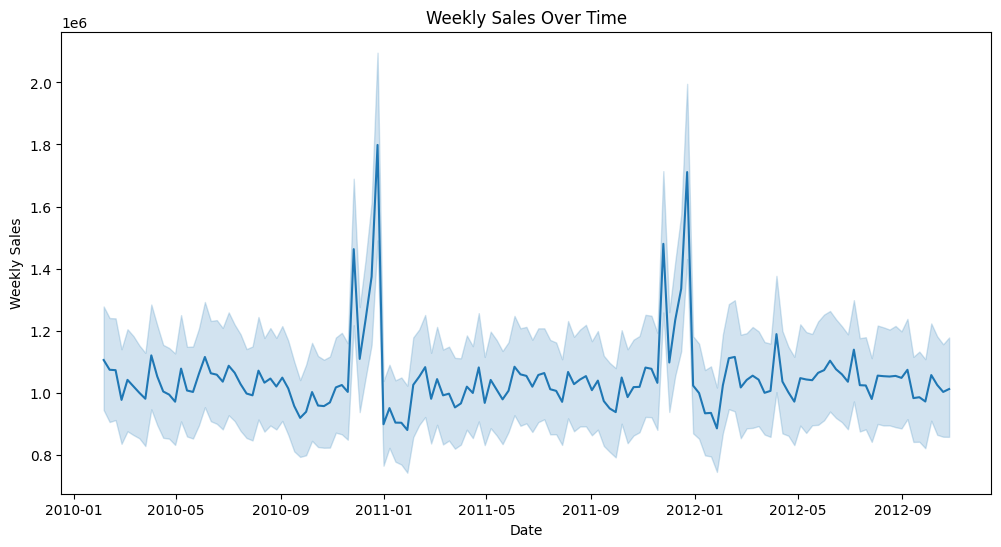

In [12]:
# Visualize the data
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Weekly_Sales', data=data)
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

The sales spike during the festive season and significantly drop in the month of January

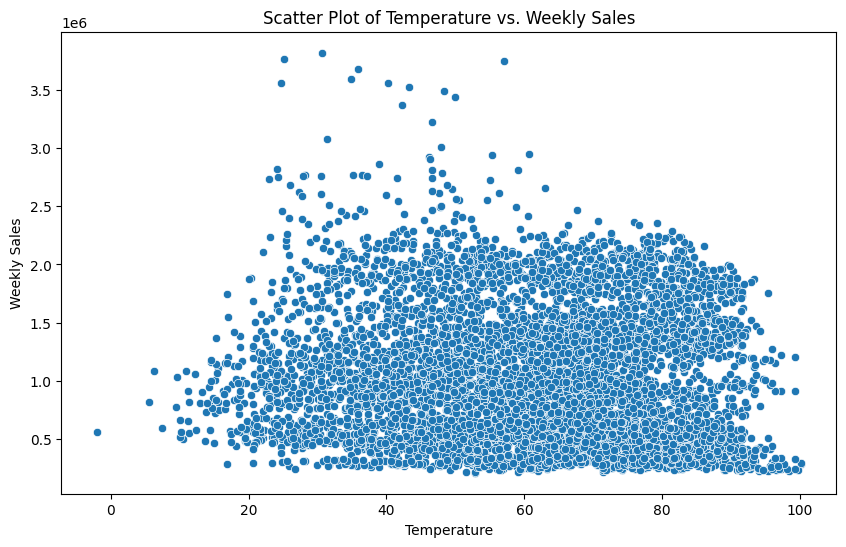

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=data)
plt.title('Scatter Plot of Temperature vs. Weekly Sales')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.show()

In [14]:
#sns.pairplot(data[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])
#plt.show()

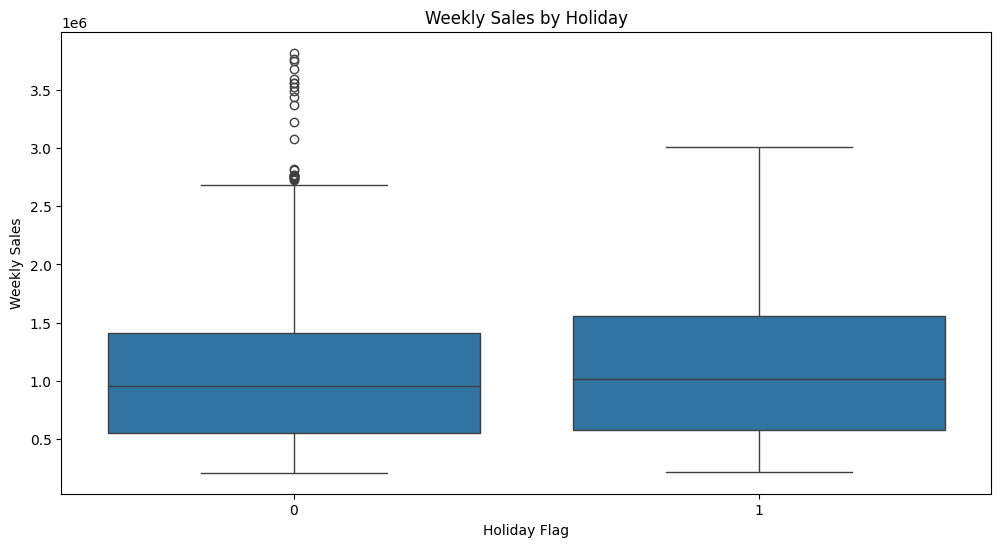

In [15]:
#Visualizing sales statistics on normal days and holidays
plt.figure(figsize=(12, 6))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=data)
plt.title('Weekly Sales by Holiday')
plt.xlabel('Holiday Flag')
plt.ylabel('Weekly Sales')
plt.show()

Avergae sale are higher during holidays as compared to non-holiday days

<Axes: xlabel='Month'>

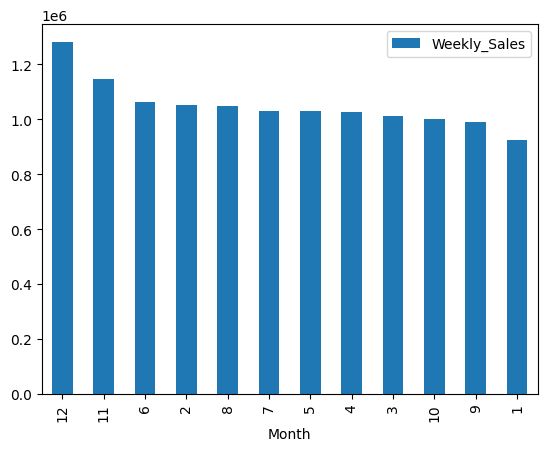

In [16]:
data[['Month','Weekly_Sales']].groupby(['Month'],as_index=True).mean().sort_values(by='Weekly_Sales',ascending=False).plot.bar()

In [17]:
data[['Year','Weekly_Sales']].groupby(['Year'],as_index=True).mean().sort_values(by='Weekly_Sales',ascending=False)#.plot.bar()

,Weekly_Sales
Year,
2010,1.059670e+06
2011,1.046239e+06
2012,1.033660e+06


In [18]:
data[['Year','CPI']].groupby(['Year'],as_index=True).mean().sort_values(by='CPI',ascending=False)

,CPI
Year,
2012,175.498781
2011,171.545716
2010,168.101782


Yearly sales total decreased between 2010 to 2012 which corresponds to the increase in cunsumer price index with the sampe period indication less buying power from the customers/

In [19]:

# Correlation analysis
correlation_matrix = data.corr()

<ipython-input-19-691948fe06a2>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


<ipython-input-20-2075812ec6b9>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


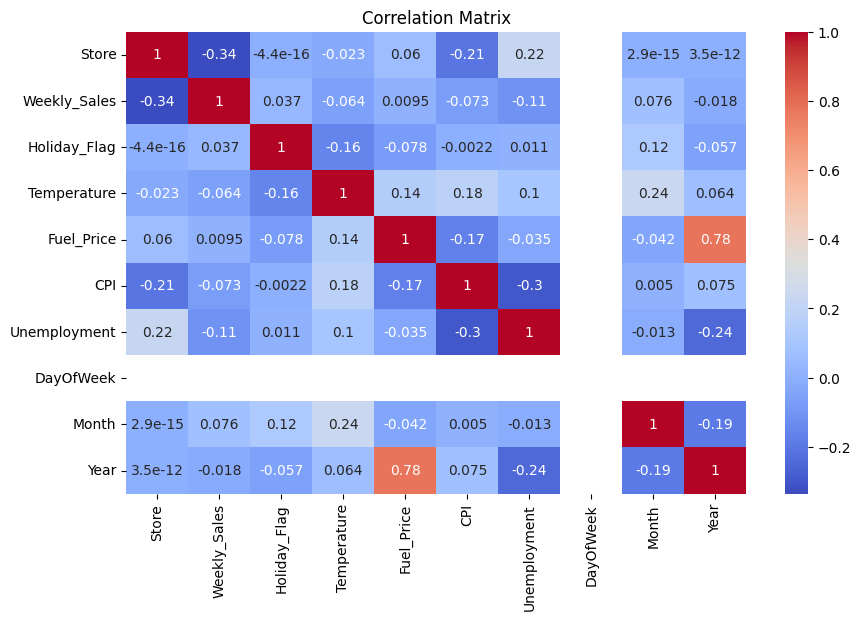

In [20]:
# Correlation matrix
correlation_matrix = data.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Time-Series Analysis

In [21]:
#visualize the underlying components of the time series, including trend, seasonality, and residual.
decomposition = seasonal_decompose(data['Weekly_Sales'], period=7)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

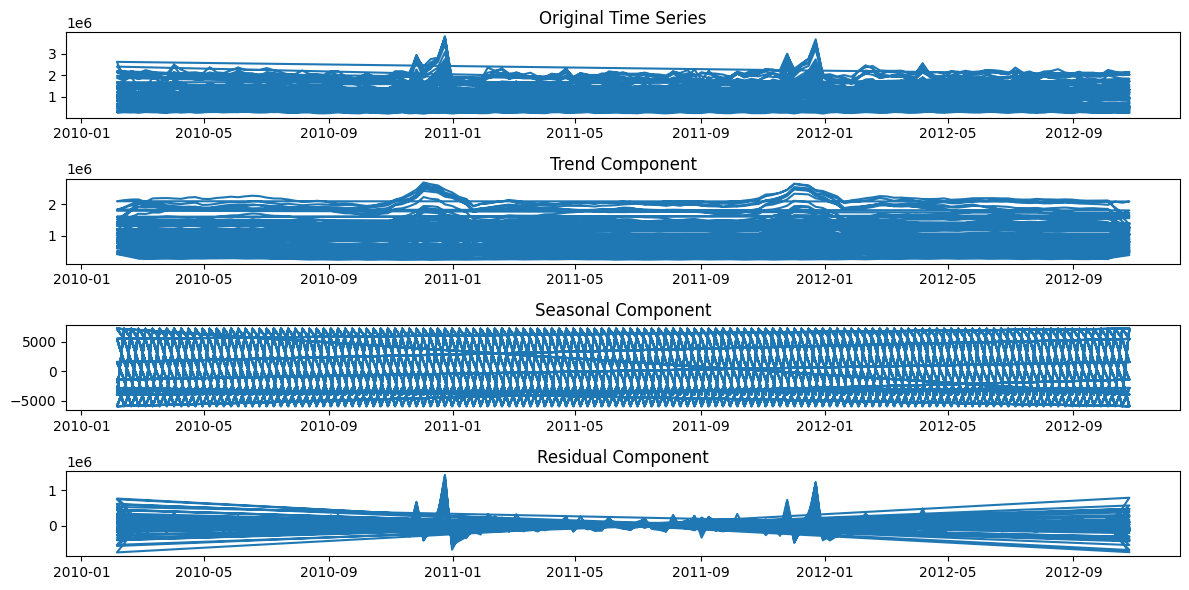

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(data['Date'], data['Weekly_Sales'], label='Original')
plt.title('Original Time Series')
plt.subplot(412)
plt.plot(data['Date'], trend, label='Trend')
plt.title('Trend Component')
plt.subplot(413)
plt.plot(data['Date'], seasonal, label='Seasonal')
plt.title('Seasonal Component')
plt.subplot(414)
plt.plot(data['Date'], residual, label='Residual')
plt.title('Residual Component')
plt.tight_layout()
plt.show()

Analysis:

* The "Original Weekly Sales" plot shows the observed weekly sales data.
* The "Trend Component" show an upward  trend over the festive season which is essentially November and December months.
* The "Seasonal Component" plot exhibits monthly seasonality upward and downward patterns.

# Machine Learning Modeling

We have decided to compare three ML models namely:
* Linear Regression
* Random Forest Regressor
* SARIMA (Seasonal Autoregressive Integrated Moving Average)
We will compare the three models and pick the best perfoming model

In [23]:
data.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'DayOfWeek', 'Month', 'Year'],
      dtype='object')

In [24]:
# Split the data into features and target variable
X = data[['Store', 'Holiday_Flag', 'CPI', 'DayOfWeek', 'Month', 'Year']]
y = data['Weekly_Sales']

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [26]:
# Create a Linear Regression model
linear_model = LinearRegression()

In [27]:
# Fit the model to the training data
linear_model.fit(X_train, y_train)

LinearRegression()

In [28]:
# Get the coefficients of the Linear Regression model
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': linear_model.coef_})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)
print('Linear Regression Coefficients:')
print(coefficients)

Linear Regression Coefficients:
        Feature   Coefficient
1  Holiday_Flag  6.378827e+04
4         Month  1.367282e+04
5          Year  4.234399e+03
3     DayOfWeek  4.001777e-11
2           CPI -2.086117e+03
0         Store -1.571423e+04


In [29]:
# Predict sales on the test set
y_pred_linear = linear_model.predict(X_test)

In [30]:
# Calculate evaluation metrics for Linear Regression
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(f'Linear Regression Mean Squared Error (MSE): {mse_linear}')
print(f'Linear Regression Mean Absolute Error (MAE): {mae_linear}')
print(f'Linear Regression R-squared (R2): {r2_linear}')

Linear Regression Mean Squared Error (MSE): 274358062063.70114
Linear Regression Mean Absolute Error (MAE): 434468.76306282723
Linear Regression R-squared (R2): 0.148365125989673


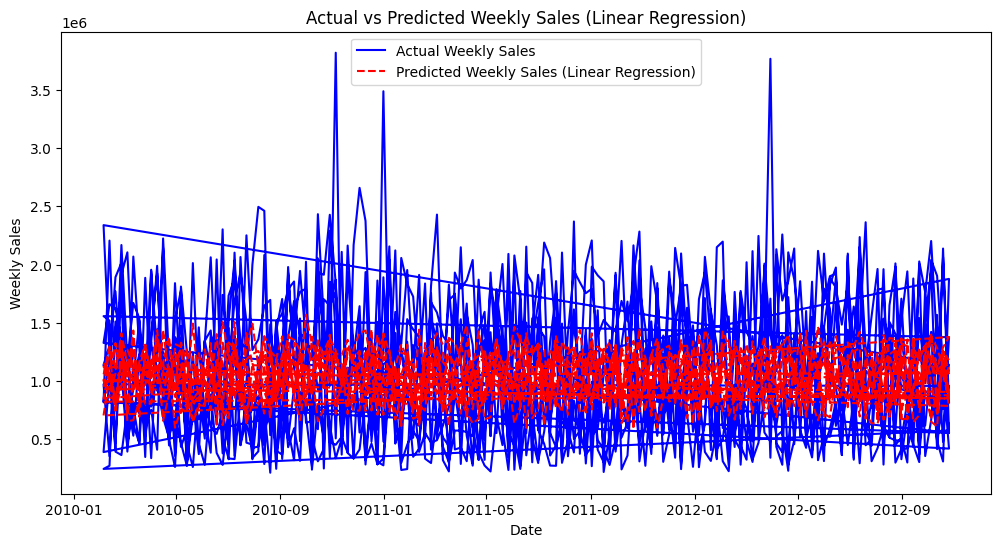

In [31]:
# Plot actual vs predicted sales for Linear Regression
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][len(data)-len(y_test):], y_test, label='Actual Weekly Sales', color='blue')
plt.plot(data['Date'][len(data)-len(y_test):], y_pred_linear, label='Predicted Weekly Sales (Linear Regression)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Actual vs Predicted Weekly Sales (Linear Regression)')
plt.legend()
plt.show()

# Random Forest Regressor

In [32]:
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [33]:
# Fit the model to the training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [34]:
# Predict sales on the test set
y_pred_rf = rf_model.predict(X_test)

In [35]:
# Calculate evaluation metrics for Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest Mean Squared Error (MSE): {mse_rf}')
print(f'Random Forest Mean Absolute Error (MAE): {mae_rf}')
print(f'Random Forest R-squared (R2): {r2_rf}')

Random Forest Mean Squared Error (MSE): 18565147603.976215
Random Forest Mean Absolute Error (MAE): 70494.92054607614
Random Forest R-squared (R2): 0.9423719244050338


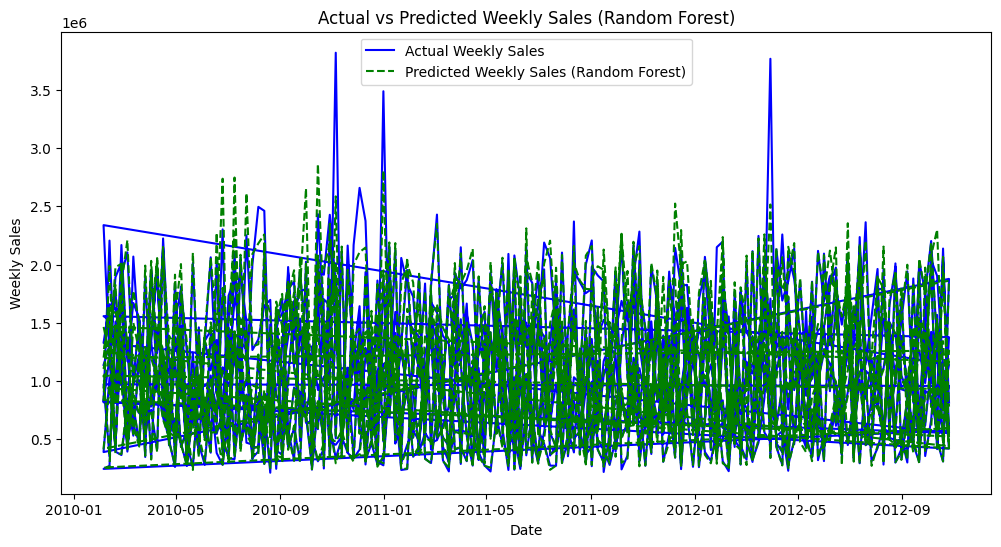

In [36]:
# Plot actual vs predicted sales for Random Forest
plt.figure(figsize=(12, 6))
plt.plot(data['Date'][len(data)-len(y_test):], y_test, label='Actual Weekly Sales', color='blue')
plt.plot(data['Date'][len(data)-len(y_test):], y_pred_rf, label='Predicted Weekly Sales (Random Forest)', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Actual vs Predicted Weekly Sales (Random Forest)')
plt.legend()
plt.show()

In [37]:
# Get feature importances for Random Forest
rf_feature_importance = rf_model.feature_importances_

# Pair feature names with their importance scores
feature_names = X.columns
rf_feature_importance_dict = dict(zip(feature_names, rf_feature_importance))

# Sort features by importance in descending order
rf_sorted_feature_importance = sorted(rf_feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print('Random Forest Feature Importance:')
for feature, importance in rf_sorted_feature_importance:
    print(f'{feature}: {importance}')

Random Forest Feature Importance:
Store: 0.764231221832417
CPI: 0.18648012826680344
Month: 0.037763010795528025
Holiday_Flag: 0.006533810476728714
Year: 0.004991828628522889
DayOfWeek: 0.0


# Time Series Forecasting - SARIMA

In [38]:
# Sort the data by date for time series analysis
data.sort_values('Date', inplace=True)

In [39]:
# Create a SARIMA model for weekly sales forecasting
sarima_model = SARIMAX(data['Weekly_Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [40]:
# Calculate SARIMA predictions on the training data
y_pred_sarima_training = sarima_results.predict(start=0, end=len(X_train) - 1)

In [41]:
# Calculate MSE and MAE for SARIMA on the training data
mse_sarima_training = mean_squared_error(y_train, y_pred_sarima_training)
mae_sarima_training = mean_absolute_error(y_train, y_pred_sarima_training)

# Print SARIMA training accuracy metrics
print(f'SARIMA Mean Squared Error (MSE) on Training Data: {mse_sarima_training}')
print(f'SARIMA Mean Absolute Error (MAE) on Training Data: {mae_sarima_training}')

SARIMA Mean Squared Error (MSE) on Training Data: 333453854854.0664
SARIMA Mean Absolute Error (MAE) on Training Data: 476758.2187317369


In [42]:
# Forecast future sales using SARIMA
future_sales_sarima = sarima_results.forecast(steps=len(X_test))
future_data = X_test.copy()
future_data['Predicted_Weekly_Sales_SARIMA'] = future_sales_sarima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [43]:
# Calculate evaluation metrics for SARIMA on the test data
mse_sarima = mean_squared_error(y_test, future_sales_sarima)
mae_sarima = mean_absolute_error(y_test, future_sales_sarima)
r2_sarima = r2_score(y_test, future_sales_sarima)
print(f'SARIMA Mean Squared Error (MSE) on Test Data: {mse_sarima}')
print(f'SARIMA Mean Absolute Error (MAE) on Test Data: {mae_sarima}')
print(f'SARIMA R-squared (R2) on Test Data: {r2_sarima}')

SARIMA Mean Squared Error (MSE) on Test Data: 326112197408.22424
SARIMA Mean Absolute Error (MAE) on Test Data: 472425.54436265526
SARIMA R-squared (R2) on Test Data: -0.012284888090878132


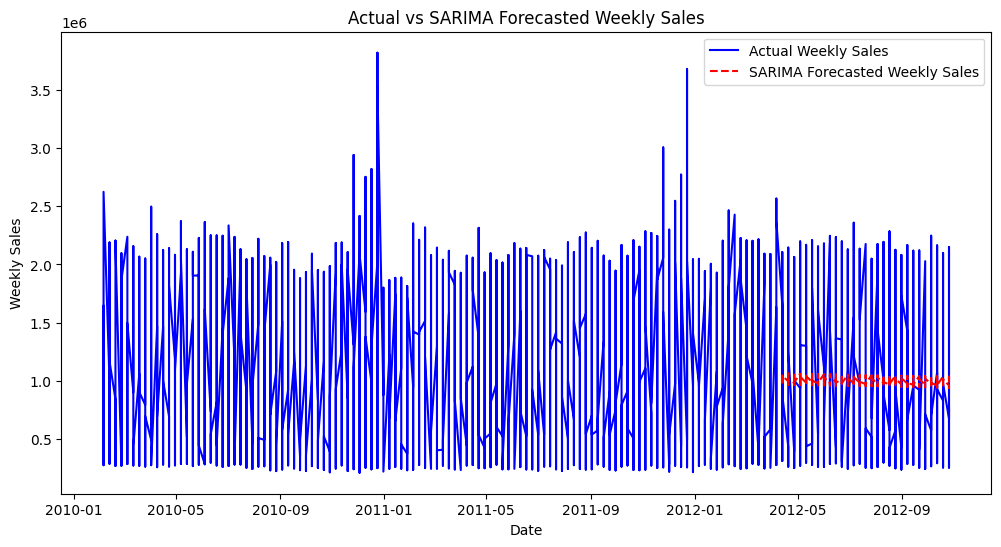

In [44]:
# Plot actual vs predicted sales for SARIMA
plt.figure(figsize=(12, 6))
# Plot actual sales for the historical data
plt.plot(data['Date'], data['Weekly_Sales'], label='Actual Weekly Sales', color='blue')
# Plot SARIMA forecast for the future data
plt.plot(data['Date'].iloc[-len(X_test):], future_sales_sarima, label='SARIMA Forecasted Weekly Sales', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Actual vs SARIMA Forecasted Weekly Sales')
plt.legend()
plt.show()

# Comparing all 3 models

In [45]:
# Compare model accuracies
print(f'Linear Regression Mean Squared Error (MSE): {mse_linear}')
print(f'Random Forest Mean Squared Error (MSE): {mse_rf}')
print(f'SARIMA Mean Squared Error (MSE): {mse_sarima}')

Linear Regression Mean Squared Error (MSE): 274358062063.70114
Random Forest Mean Squared Error (MSE): 18565147603.976215
SARIMA Mean Squared Error (MSE): 326112197408.22424


Random Forest model gives the best results with the lowest MSE and an R2 value of 0.9423719244050338

Linear regreassion has an MSE 274358062063 and an R2 value of 0.148365125989673, which shows that the data is non linear and does not fit a linear model.

The SARIMA model gives the worst results but with some changes it can be improved to give better results